In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import tensorflow as tf
import tensorflow_decision_forests as tfdf

%matplotlib inline
warnings.filterwarnings('ignore')

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [2]:
## 讀取檔案

train = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/train.csv')
test = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/test.csv')
submit = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv')

In [3]:
## 訓練集大小

train.shape

(1460, 81)

In [4]:
## 觀察train資料

train.head(3)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500


In [5]:
## 資料檢查

train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [6]:
## 把訓練集和測試集合併成一個資料
## 之後修改資料可一次修改，不用分train or test

data = pd.concat([train, test], ignore_index=True)
data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500.0
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500.0
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500.0
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000.0
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000.0


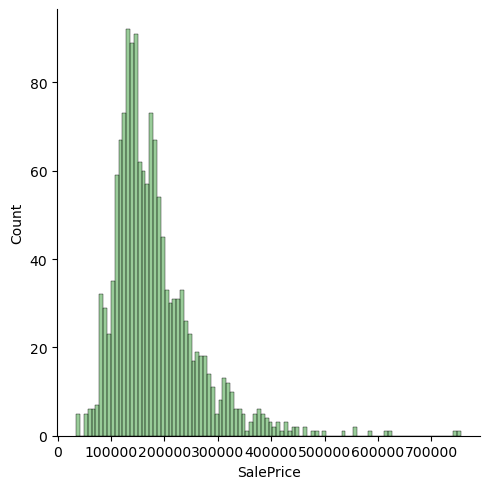

In [7]:
## 參考tutorial的方式作圖，得知SalePrice在資料中的分布
## 可以看出資料為線性分布
## 接近常態分佈

sns.displot(train['SalePrice'], color='g', bins=100, alpha=0.4)

In [8]:
## 目前特徵較多，觀察特徵的型態
## dtype('O')是NumPy中對於"object"類型的數據的表示方式，
## 一般使用dtype('O')表示相同的數據類型
## dtype=object是Pandas中對於"object"類型的數據的表示方式，
## 當一個列包含不同類型的數據（如字串、數字、None等）時，該列的數據類型將被指定為dtype=object。

data_types = data.dtypes.unique()
data_types

array([dtype('int64'), dtype('O'), dtype('float64')], dtype=object)

In [9]:
data.shape

(2919, 81)

In [10]:
## 選出數值特徵
## 用select_dtypes去將資料型態做分類

data_num = data.select_dtypes(include=['float64', 'int64'])

In [11]:
data_num.head(3)

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
0,1,60,65.0,8450,7,5,2003,2003,196.0,706.0,...,0,61,0,0,0,0,0,2,2008,208500.0
1,2,20,80.0,9600,6,8,1976,1976,0.0,978.0,...,298,0,0,0,0,0,0,5,2007,181500.0
2,3,60,68.0,11250,7,5,2001,2002,162.0,486.0,...,0,42,0,0,0,0,0,9,2008,223500.0


In [12]:
## 看data_num的空值

data_num.isnull().sum()

Id                  0
MSSubClass          0
LotFrontage       486
LotArea             0
OverallQual         0
OverallCond         0
YearBuilt           0
YearRemodAdd        0
MasVnrArea         23
BsmtFinSF1          1
BsmtFinSF2          1
BsmtUnfSF           1
TotalBsmtSF         1
1stFlrSF            0
2ndFlrSF            0
LowQualFinSF        0
GrLivArea           0
BsmtFullBath        2
BsmtHalfBath        2
FullBath            0
HalfBath            0
BedroomAbvGr        0
KitchenAbvGr        0
TotRmsAbvGrd        0
Fireplaces          0
GarageYrBlt       159
GarageCars          1
GarageArea          1
WoodDeckSF          0
OpenPorchSF         0
EnclosedPorch       0
3SsnPorch           0
ScreenPorch         0
PoolArea            0
MiscVal             0
MoSold              0
YrSold              0
SalePrice        1459
dtype: int64

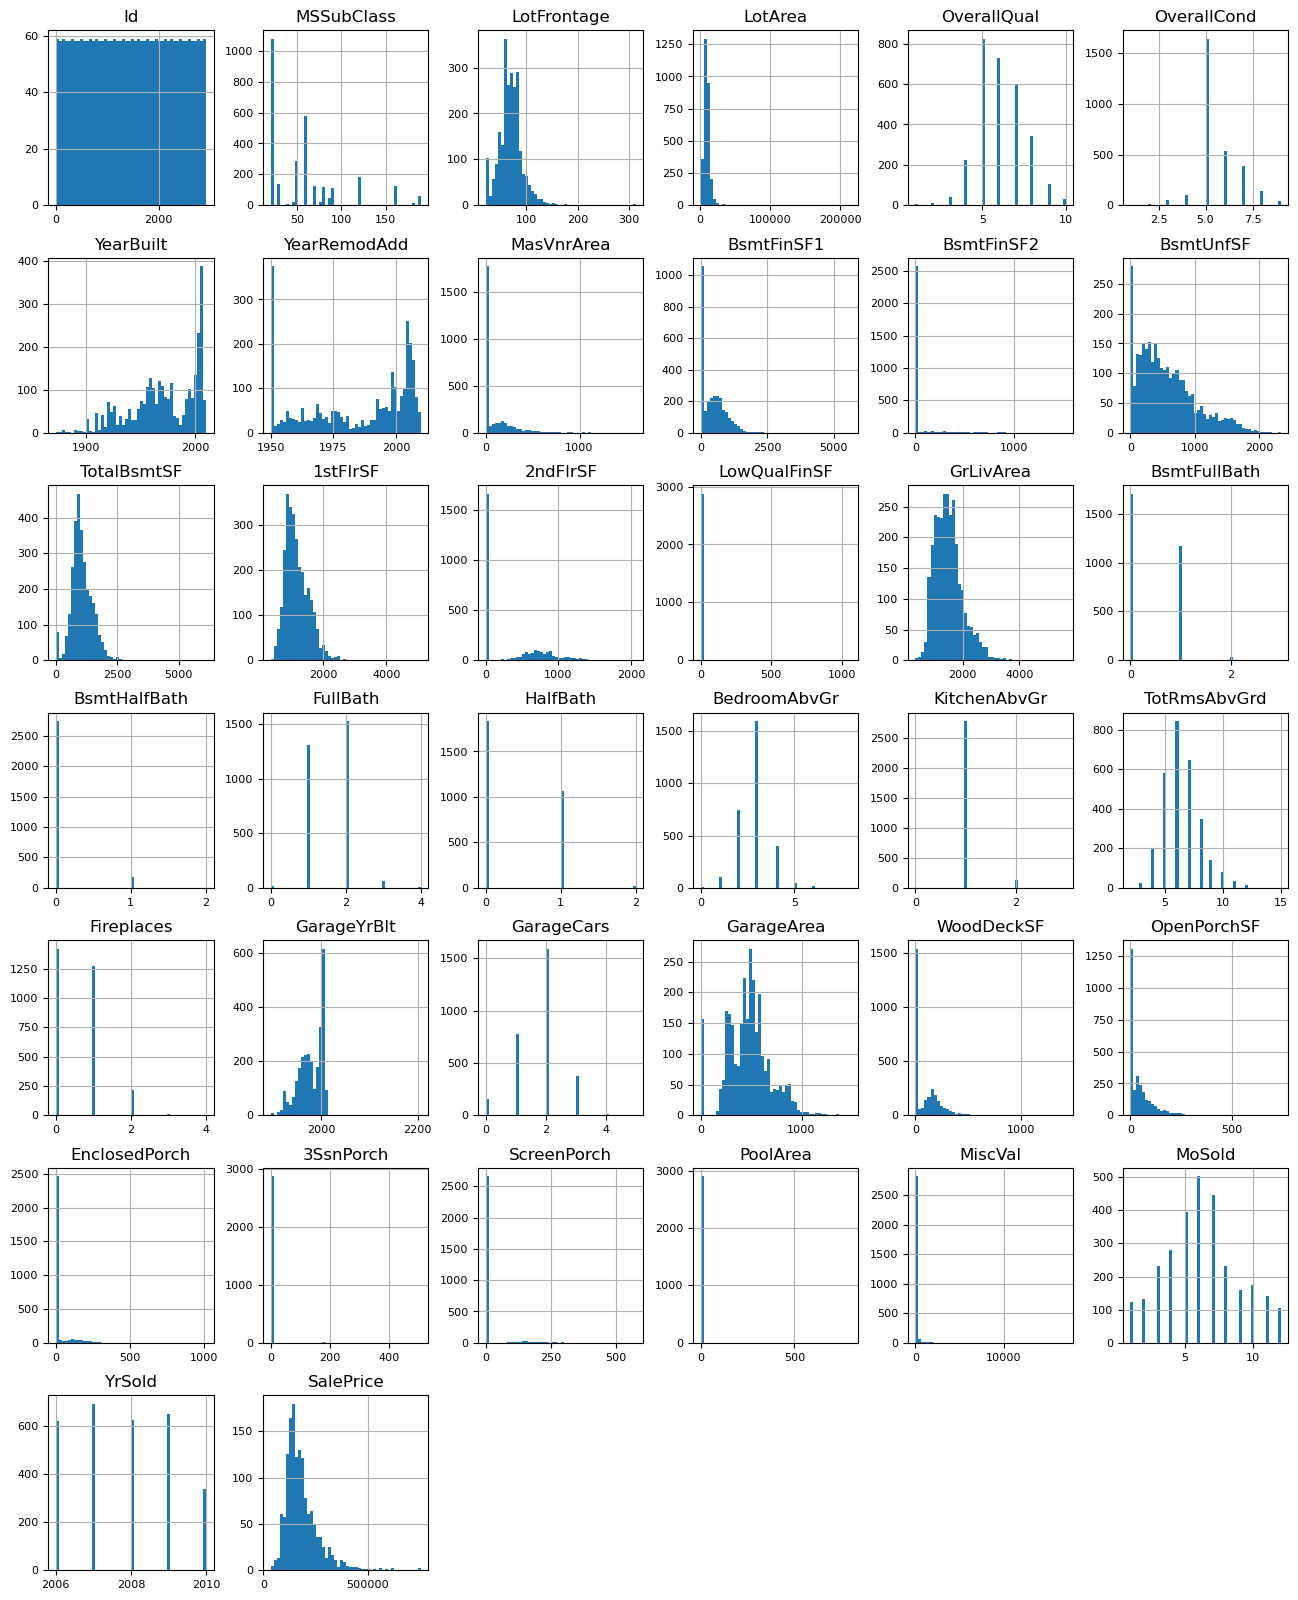

In [13]:
## 顯示數值特徵在不同值範圍的頻率分佈情況

data_num.hist(figsize=(16, 20), bins=50, xlabelsize=8, ylabelsize=8);

In [14]:
## 計算(Pearson)相關係數
## 並篩選出相關性較高的特徵
## >0.4

data_num_corr = data_num.corr()
num_targetCorr = data_num_corr['SalePrice']
num_targetCorr = num_targetCorr.drop('SalePrice')
num_features = num_targetCorr[abs(num_targetCorr)>0.4]
print('選擇特徵數：{} \n選擇特徵：\n{}'.format(len(num_features), num_features))

選擇特徵數：13 
選擇特徵：
OverallQual     0.790982
YearBuilt       0.522897
YearRemodAdd    0.507101
MasVnrArea      0.477493
TotalBsmtSF     0.613581
1stFlrSF        0.605852
GrLivArea       0.708624
FullBath        0.560664
TotRmsAbvGrd    0.533723
Fireplaces      0.466929
GarageYrBlt     0.486362
GarageCars      0.640409
GarageArea      0.623431
Name: SalePrice, dtype: float64


In [15]:
## 取出相關的數值特徵

num_selected_features = num_features.index.tolist()
print(num_selected_features)

['OverallQual', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'TotalBsmtSF', '1stFlrSF', 'GrLivArea', 'FullBath', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea']


In [16]:
# ## 重新賦予data_num

# data_num = data_num[num_selected_features]
# data_num.shape

In [17]:
## 觀察object型態的資料

data_obj = data.select_dtypes(include=['object'])
data_obj.head(3)

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,...,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
0,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
1,RL,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
2,RL,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal


In [18]:
## Alley, FireplaceQu, PoolQC, Fence, MiscFeature 的缺失值較多，且都是object屬性
## FireplaceQu(Fireplace quality)較特別可另外討論
## 因此決並把Alley, PoolQC, Fence, MiscFeature移除

# data_obj = data_obj.drop(['Alley', 'PoolQC', 'Fence', 'MiscFeature'], axis=1)
# data_obj.head(3)

In [19]:
## 從object的特徵中找出高佔比的類別
## 若佔比高達一定程度，推測其對目標的相關度不高，可考慮省略
## 設定佔比:90

obj_drop = []
for i in range(len(data_obj.columns)):
    ##計算每個類別的頻數
    category_counts = data_obj.iloc[:,i].value_counts()
    # 找到佔比最多的類別及其佔比
    most_common_category = category_counts.idxmax()
    most_common_category_count = category_counts.max()
    percentage = most_common_category_count / len(data) * 100
    if percentage >= 90:
        # 打印結果
        obj_drop.append(data_obj.columns[i])
        print("佔比最多的類別：", most_common_category)
        print("佔比：", percentage)

佔比最多的類別： Pave
佔比： 99.58890030832477
佔比最多的類別： AllPub
佔比： 99.8972250770812
佔比最多的類別： Gtl
佔比： 95.16957862281603
佔比最多的類別： Norm
佔比： 98.97225077081193
佔比最多的類別： CompShg
佔比： 98.52689277149709
佔比最多的類別： GasA
佔比： 98.45837615621788
佔比最多的類別： Y
佔比： 93.28537170263789
佔比最多的類別： SBrkr
佔比： 91.50393970537856
佔比最多的類別： Typ
佔比： 93.07982185680027
佔比最多的類別： TA
佔比： 90.9215484755053
佔比最多的類別： Y
佔比： 90.47619047619048


In [20]:
obj_drop

['Street',
 'Utilities',
 'LandSlope',
 'Condition2',
 'RoofMatl',
 'Heating',
 'CentralAir',
 'Electrical',
 'Functional',
 'GarageCond',
 'PavedDrive']

In [21]:
# ## 把同類型站比高於90%的特徵從data中移除

# data_obj = data_obj.drop(obj_drop, axis=1)
# data_obj.head(3)

In [22]:
## 觀察篩選過後的資料並填補空值

data_num.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2919 entries, 0 to 2918
Data columns (total 38 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             2919 non-null   int64  
 1   MSSubClass     2919 non-null   int64  
 2   LotFrontage    2433 non-null   float64
 3   LotArea        2919 non-null   int64  
 4   OverallQual    2919 non-null   int64  
 5   OverallCond    2919 non-null   int64  
 6   YearBuilt      2919 non-null   int64  
 7   YearRemodAdd   2919 non-null   int64  
 8   MasVnrArea     2896 non-null   float64
 9   BsmtFinSF1     2918 non-null   float64
 10  BsmtFinSF2     2918 non-null   float64
 11  BsmtUnfSF      2918 non-null   float64
 12  TotalBsmtSF    2918 non-null   float64
 13  1stFlrSF       2919 non-null   int64  
 14  2ndFlrSF       2919 non-null   int64  
 15  LowQualFinSF   2919 non-null   int64  
 16  GrLivArea      2919 non-null   int64  
 17  BsmtFullBath   2917 non-null   float64
 18  BsmtHalf

In [23]:
# LotFrontage      486
# MasVnrArea        23
# BsmtFinSF1         1  填0
# BsmtFinSF2         1  填0
# BsmtUnfSF          1  填0
# TotalBsmtSF        1  
# BsmtFullBath       2  填0
# BsmtHalfBath       2  填0
# GarageYrBlt      159
# GarageCars         1
# GarageArea         1

In [24]:
## MasVnrArea, TotalBsmtSF, GarageYrBlt, GarageCars, GarageArea有空值

data_num['BsmtFinSF1'] = data_num['BsmtFinSF1'].fillna(0)
data_num['BsmtFinSF2'] = data_num['BsmtFinSF2'].fillna(0)
data_num['BsmtUnfSF'] = data_num['BsmtUnfSF'].fillna(0)
data_num['BsmtFullBath'] = data_num['BsmtFullBath'].fillna(0)
data_num['BsmtHalfBath'] = data_num['BsmtHalfBath'].fillna(0)
data_num['LotFrontage'] = data_num['LotFrontage'].fillna(data_num['LotFrontage'].mean())
data_num['MasVnrArea'] = data_num['MasVnrArea'].fillna(data_num['MasVnrArea'].mean())
data_num['TotalBsmtSF'] = data_num['TotalBsmtSF'].fillna(data_num['TotalBsmtSF'].mean())
data_num['GarageYrBlt'] = data_num['GarageYrBlt'].fillna(data_num['GarageYrBlt'].mean())
data_num['GarageCars'] = data_num['GarageCars'].fillna(data_num['GarageCars'].mean())
data_num['GarageArea'] = data_num['GarageArea'].fillna(data_num['GarageArea'].mean())

In [25]:
## 確認空值是否補上

data_num.isnull().sum()

Id                  0
MSSubClass          0
LotFrontage         0
LotArea             0
OverallQual         0
OverallCond         0
YearBuilt           0
YearRemodAdd        0
MasVnrArea          0
BsmtFinSF1          0
BsmtFinSF2          0
BsmtUnfSF           0
TotalBsmtSF         0
1stFlrSF            0
2ndFlrSF            0
LowQualFinSF        0
GrLivArea           0
BsmtFullBath        0
BsmtHalfBath        0
FullBath            0
HalfBath            0
BedroomAbvGr        0
KitchenAbvGr        0
TotRmsAbvGrd        0
Fireplaces          0
GarageYrBlt         0
GarageCars          0
GarageArea          0
WoodDeckSF          0
OpenPorchSF         0
EnclosedPorch       0
3SsnPorch           0
ScreenPorch         0
PoolArea            0
MiscVal             0
MoSold              0
YrSold              0
SalePrice        1459
dtype: int64

In [26]:
## 觀察篩選過後的資料並填補空值

data_obj.isnull().sum()

MSZoning            4
Street              0
Alley            2721
LotShape            0
LandContour         0
Utilities           2
LotConfig           0
LandSlope           0
Neighborhood        0
Condition1          0
Condition2          0
BldgType            0
HouseStyle          0
RoofStyle           0
RoofMatl            0
Exterior1st         1
Exterior2nd         1
MasVnrType         24
ExterQual           0
ExterCond           0
Foundation          0
BsmtQual           81
BsmtCond           82
BsmtExposure       82
BsmtFinType1       79
BsmtFinType2       80
Heating             0
HeatingQC           0
CentralAir          0
Electrical          1
KitchenQual         1
Functional          2
FireplaceQu      1420
GarageType        157
GarageFinish      159
GarageQual        159
GarageCond        159
PavedDrive          0
PoolQC           2909
Fence            2348
MiscFeature      2814
SaleType            1
SaleCondition       0
dtype: int64

In [27]:
## MSZoning(4), Exterior1st(1), Exterior2nd(1), MasVnrType(24), BsmtQual
## BsmtCond, BsmtExposure, BsmtFinType1, BsmtFinType2, KitchenQual(1)
## FireplaceQu, GarageType, GarageFinish, GarageQual, SaleType(1) 有空值

obj_filled = ['MSZoning', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'KitchenQual', 'SaleType', 'Electrical', 'Functional', 'Utilities']

## 將缺失值較少的特徵以最多占比的類別填入空值
for feature in obj_filled:
    ## 獲取特徵中出現最多次的類別
    most_common_category = data_obj[feature].mode().iloc[0]
    ## 將空值填入出現最多次的類別
    data_obj[feature].fillna(most_common_category, inplace=True)

## 確認是否空值已被填滿

print(data_obj.isnull().sum())

MSZoning            0
Street              0
Alley            2721
LotShape            0
LandContour         0
Utilities           0
LotConfig           0
LandSlope           0
Neighborhood        0
Condition1          0
Condition2          0
BldgType            0
HouseStyle          0
RoofStyle           0
RoofMatl            0
Exterior1st         0
Exterior2nd         0
MasVnrType          0
ExterQual           0
ExterCond           0
Foundation          0
BsmtQual           81
BsmtCond           82
BsmtExposure       82
BsmtFinType1       79
BsmtFinType2       80
Heating             0
HeatingQC           0
CentralAir          0
Electrical          0
KitchenQual         0
Functional          0
FireplaceQu      1420
GarageType        157
GarageFinish      159
GarageQual        159
GarageCond        159
PavedDrive          0
PoolQC           2909
Fence            2348
MiscFeature      2814
SaleType            0
SaleCondition       0
dtype: int64


In [28]:
## 這邊剩下來的空值都偏多，參考了一下discussion的方法
## I solved this by creating an N/A category to handle
## the non existence of the fireplaces and other home amenities.
## I also did the same for their Quality rankings.
## I ended up making a custom Ordinal encoder to rank the qualities and conditions columns
## with N/A being represented by 0.
## 仔細去看缺失值的特徵，多數是有好壞等級之分的資料
## 因此我們可以將特徵的類別轉成數字，並設空值為最低分
## 剩這九項:
## BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,FireplaceQu,GarageType,GarageFinish,GarageQual

In [29]:
## 觀察特徵內有哪些類別

feature_list = ['Alley', 'BsmtQual', 'BsmtCond', 'FireplaceQu', 'GarageQual', 'BsmtFinType1', 'BsmtFinType2', 'BsmtExposure', 'GarageType', 'GarageFinish']
for feature in feature_list:
    print(feature)
    print(data_obj[feature].unique())

Alley
[nan 'Grvl' 'Pave']
BsmtQual
['Gd' 'TA' 'Ex' nan 'Fa']
BsmtCond
['TA' 'Gd' nan 'Fa' 'Po']
FireplaceQu
[nan 'TA' 'Gd' 'Fa' 'Ex' 'Po']
GarageQual
['TA' 'Fa' 'Gd' nan 'Ex' 'Po']
BsmtFinType1
['GLQ' 'ALQ' 'Unf' 'Rec' 'BLQ' nan 'LwQ']
BsmtFinType2
['Unf' 'BLQ' nan 'ALQ' 'Rec' 'LwQ' 'GLQ']
BsmtExposure
['No' 'Gd' 'Mn' 'Av' nan]
GarageType
['Attchd' 'Detchd' 'BuiltIn' 'CarPort' nan 'Basment' '2Types']
GarageFinish
['RFn' 'Unf' 'Fin' nan]


In [30]:
## 填補剩下的9個空值

obj_filled_2 = ['Alley', 'BsmtQual', 'BsmtCond', 'FireplaceQu', 'GarageQual', 'BsmtFinType1', 'BsmtFinType2', 'BsmtExposure', 'GarageType', 'GarageFinish']

for feature in obj_filled_2:
    data_obj[feature] = data_obj[feature].fillna('NA')
    
## 確認是否填補資料

print(data_obj.isnull().sum())

MSZoning            0
Street              0
Alley               0
LotShape            0
LandContour         0
Utilities           0
LotConfig           0
LandSlope           0
Neighborhood        0
Condition1          0
Condition2          0
BldgType            0
HouseStyle          0
RoofStyle           0
RoofMatl            0
Exterior1st         0
Exterior2nd         0
MasVnrType          0
ExterQual           0
ExterCond           0
Foundation          0
BsmtQual            0
BsmtCond            0
BsmtExposure        0
BsmtFinType1        0
BsmtFinType2        0
Heating             0
HeatingQC           0
CentralAir          0
Electrical          0
KitchenQual         0
Functional          0
FireplaceQu         0
GarageType          0
GarageFinish        0
GarageQual          0
GarageCond        159
PavedDrive          0
PoolQC           2909
Fence            2348
MiscFeature      2814
SaleType            0
SaleCondition       0
dtype: int64


In [31]:
## 數值部分以及物件部分的空值皆已處理好，將兩者資料合併成一物件，之後處理較方便

data_all = pd.concat([data_num, data_obj], axis=1)
data_all.head()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
0,1,60,65.0,8450,7,5,2003,2003,196.0,706.0,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
1,2,20,80.0,9600,6,8,1976,1976,0.0,978.0,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
2,3,60,68.0,11250,7,5,2001,2002,162.0,486.0,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
3,4,70,60.0,9550,7,5,1915,1970,0.0,216.0,...,Detchd,Unf,TA,TA,Y,NaN,NaN,NaN,WD,Abnorml
4,5,60,84.0,14260,8,5,2000,2000,350.0,655.0,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal


In [32]:
## 確認特徵內有類別是否轉換成功

feature_list = ['BsmtQual', 'BsmtCond', 'FireplaceQu', 'GarageQual', 'BsmtFinType1', 'BsmtFinType2', 'BsmtExposure', 'GarageType', 'GarageFinish']
for feature in feature_list:
    print(feature)
    print(data_obj[feature].unique())

BsmtQual
['Gd' 'TA' 'Ex' 'NA' 'Fa']
BsmtCond
['TA' 'Gd' 'NA' 'Fa' 'Po']
FireplaceQu
['NA' 'TA' 'Gd' 'Fa' 'Ex' 'Po']
GarageQual
['TA' 'Fa' 'Gd' 'NA' 'Ex' 'Po']
BsmtFinType1
['GLQ' 'ALQ' 'Unf' 'Rec' 'BLQ' 'NA' 'LwQ']
BsmtFinType2
['Unf' 'BLQ' 'NA' 'ALQ' 'Rec' 'LwQ' 'GLQ']
BsmtExposure
['No' 'Gd' 'Mn' 'Av' 'NA']
GarageType
['Attchd' 'Detchd' 'BuiltIn' 'CarPort' 'NA' 'Basment' '2Types']
GarageFinish
['RFn' 'Unf' 'Fin' 'NA']


In [33]:
## Ex,Gd,TA,Fa,Po,NA:BsmtQual, BsmtCond, FireplaceQu, GarageQual
## GLQ,ALQ,BLQ,Rec,LwQ,Unf,NA:BsmtFinType1, BsmtFinType2

# BsmtExposure
#        Gd	Good Exposure
#        Av	Average Exposure (split levels or foyers typically score average or above)	
#        Mn	Mimimum Exposure
#        No	No Exposure
#        NA	No Basement

# GarageFinish
#        Fin	Finished
#        RFn	Rough Finished
#        Unf	Unfinished
#        NA  	No Garage

In [34]:
## 接下來進行非數值資料的轉換
## 觀察這28個非數值特徵類別的分類
## 可以簡單分成: 類別之間有順序 或 類別之間個別獨立
## 類別間有順序的也就是上面空值較多的9項
## 但是GarageType我覺得比較偏向獨立
## 因此只有八項是有等級順序的

In [35]:
## 有等級順序的非數值轉換

dict1 = {'Ex':5, 'Gd':4, 'TA':3, 'Fa':2, 'Po':1, 'NA':0}
feature1 = ['BsmtQual', 'BsmtCond', 'FireplaceQu', 'GarageQual']
for feature in feature1:
    data_all[feature].replace(dict1, inplace=True)
    
dict2 = {'GLQ':6,'ALQ':5,'BLQ':4,'Rec':3,'LwQ':2,'Unf':1,'NA':0}
feature2 = ['BsmtFinType1', 'BsmtFinType2']
for feature in feature2:
    data_all[feature].replace(dict2, inplace=True)
    
dict3 = {'Gd':4, 'Av':3, 'Mn':2, 'No':1, 'NA':0}
feature3 = ['BsmtExposure']
for feature in feature3:
    data_all[feature].replace(dict3, inplace=True)
    
dict4 = {'Fin':3, 'RFn':2, 'Unf':1, 'NA':0}
feature4 = ['GarageFinish']
for feature in feature4:
    data_all[feature].replace(dict4, inplace=True)

In [36]:
data_all.head(3)

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
0,1,60,65.0,8450,7,5,2003,2003,196.0,706.0,...,Attchd,2,3,TA,Y,NaN,NaN,NaN,WD,Normal
1,2,20,80.0,9600,6,8,1976,1976,0.0,978.0,...,Attchd,2,3,TA,Y,NaN,NaN,NaN,WD,Normal
2,3,60,68.0,11250,7,5,2001,2002,162.0,486.0,...,Attchd,2,3,TA,Y,NaN,NaN,NaN,WD,Normal


In [37]:
data_all.drop('SalePrice', axis=1, inplace=True)
data_final = pd.concat([data_all, data['SalePrice']], axis=1)
# data_final.insert(0, 'Id', data['Id'])
# data_final.shape
data_final.head(3)

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition,SalePrice
0,1,60,65.0,8450,7,5,2003,2003,196.0,706.0,...,2,3,TA,Y,NaN,NaN,NaN,WD,Normal,208500.0
1,2,20,80.0,9600,6,8,1976,1976,0.0,978.0,...,2,3,TA,Y,NaN,NaN,NaN,WD,Normal,181500.0
2,3,60,68.0,11250,7,5,2001,2002,162.0,486.0,...,2,3,TA,Y,NaN,NaN,NaN,WD,Normal,223500.0


In [38]:
data_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2919 entries, 0 to 2918
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             2919 non-null   int64  
 1   MSSubClass     2919 non-null   int64  
 2   LotFrontage    2919 non-null   float64
 3   LotArea        2919 non-null   int64  
 4   OverallQual    2919 non-null   int64  
 5   OverallCond    2919 non-null   int64  
 6   YearBuilt      2919 non-null   int64  
 7   YearRemodAdd   2919 non-null   int64  
 8   MasVnrArea     2919 non-null   float64
 9   BsmtFinSF1     2919 non-null   float64
 10  BsmtFinSF2     2919 non-null   float64
 11  BsmtUnfSF      2919 non-null   float64
 12  TotalBsmtSF    2919 non-null   float64
 13  1stFlrSF       2919 non-null   int64  
 14  2ndFlrSF       2919 non-null   int64  
 15  LowQualFinSF   2919 non-null   int64  
 16  GrLivArea      2919 non-null   int64  
 17  BsmtFullBath   2919 non-null   float64
 18  BsmtHalf

In [39]:
## 設定訓練資料及測試資料

dataTrain = data_final[pd.notnull(data['SalePrice'])].sort_values(by=['Id'])
dataTest = data_final[~pd.notnull(data['SalePrice'])].sort_values(by=['Id'])

In [40]:
## 列出dataTrain的欄位

dataTrain.columns

Index(['Id', 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual',
       'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd',
       'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF',
       'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea',
       'MiscVal', 'MoSold', 'YrSold', 'MSZoning', 'Street', 'Alley',
       'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrica

In [41]:
## 重新選擇欄位
## dataTrain把Id去掉
## dataTest把Id和SalePrice去掉

dataTrain = dataTrain.iloc[:, 1:]
dataTest = dataTest.iloc[:, 1:-1]

In [42]:
dataTrain.head(3)

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition,SalePrice
0,60,65.0,8450,7,5,2003,2003,196.0,706.0,0.0,...,2,3,TA,Y,NaN,NaN,NaN,WD,Normal,208500.0
1,20,80.0,9600,6,8,1976,1976,0.0,978.0,0.0,...,2,3,TA,Y,NaN,NaN,NaN,WD,Normal,181500.0
2,60,68.0,11250,7,5,2001,2002,162.0,486.0,0.0,...,2,3,TA,Y,NaN,NaN,NaN,WD,Normal,223500.0


In [43]:
dataTest.head(3)

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
1460,20,80.0,11622,5,6,1961,1961,0.0,468.0,144.0,...,Attchd,1,3,TA,Y,NaN,MnPrv,NaN,WD,Normal
1461,20,81.0,14267,6,6,1958,1958,108.0,923.0,0.0,...,Attchd,1,3,TA,Y,NaN,NaN,Gar2,WD,Normal
1462,60,74.0,13830,5,5,1997,1998,0.0,791.0,0.0,...,Attchd,3,3,TA,Y,NaN,MnPrv,NaN,WD,Normal


In [44]:
dataTrain.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1460 entries, 0 to 1459
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   LotFrontage    1460 non-null   float64
 2   LotArea        1460 non-null   int64  
 3   OverallQual    1460 non-null   int64  
 4   OverallCond    1460 non-null   int64  
 5   YearBuilt      1460 non-null   int64  
 6   YearRemodAdd   1460 non-null   int64  
 7   MasVnrArea     1460 non-null   float64
 8   BsmtFinSF1     1460 non-null   float64
 9   BsmtFinSF2     1460 non-null   float64
 10  BsmtUnfSF      1460 non-null   float64
 11  TotalBsmtSF    1460 non-null   float64
 12  1stFlrSF       1460 non-null   int64  
 13  2ndFlrSF       1460 non-null   int64  
 14  LowQualFinSF   1460 non-null   int64  
 15  GrLivArea      1460 non-null   int64  
 16  BsmtFullBath   1460 non-null   float64
 17  BsmtHalfBath   1460 non-null   float64
 18  FullBath

In [45]:
dataTest.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1459 entries, 1460 to 2918
Data columns (total 79 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1459 non-null   int64  
 1   LotFrontage    1459 non-null   float64
 2   LotArea        1459 non-null   int64  
 3   OverallQual    1459 non-null   int64  
 4   OverallCond    1459 non-null   int64  
 5   YearBuilt      1459 non-null   int64  
 6   YearRemodAdd   1459 non-null   int64  
 7   MasVnrArea     1459 non-null   float64
 8   BsmtFinSF1     1459 non-null   float64
 9   BsmtFinSF2     1459 non-null   float64
 10  BsmtUnfSF      1459 non-null   float64
 11  TotalBsmtSF    1459 non-null   float64
 12  1stFlrSF       1459 non-null   int64  
 13  2ndFlrSF       1459 non-null   int64  
 14  LowQualFinSF   1459 non-null   int64  
 15  GrLivArea      1459 non-null   int64  
 16  BsmtFullBath   1459 non-null   float64
 17  BsmtHalfBath   1459 non-null   float64
 18  FullB

In [46]:
# 參考tutorial的方法
## tensorflow or sklearn

def split_data(data, test_ratio=0.30):
  test_indices = np.random.rand(len(data)) < test_ratio
  return data[~test_indices], data[test_indices]

train_ds_pd, valid_ds_pd = split_data(dataTrain)
print("{} examples in training, {} examples in testing.".format(
    len(train_ds_pd), len(valid_ds_pd)))

1061 examples in training, 399 examples in testing.


In [47]:
# 把資料從pandas資料形式轉換成tensorflow的資料形式

label = 'SalePrice'
train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(train_ds_pd, label=label, task = tfdf.keras.Task.REGRESSION)
valid_ds = tfdf.keras.pd_dataframe_to_tf_dataset(valid_ds_pd, label=label, task = tfdf.keras.Task.REGRESSION)

In [48]:
feature_list = train_ds_pd.columns[:-1]
feature_list

Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces',
       'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'MoSold', 'YrSold', 'MSZoning', 'Street', 'Alley', 'LotShape',
       'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood',
       'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual',
       'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure',
       'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir',
       'Electrical', 'K

In [49]:
## 設定特徵權重的字典 feature_weights

## 創建一個空的特徵權重字典
feature_weights = {}

## 使用迴圈設定每個特徵的初始權重
for feature in feature_list:
    feature_weights[feature] = 1.0

## 調整特定特徵的權重
## 相關度較高的數值特徵
for feature in num_selected_features:
    feature_weights[feature] = 3.0
    
# ## 同類別占比高於九成的特徵
# for feature in obj_drop:
#     feature_weights[feature] = 0.5

In [50]:
## 建立RandomForestModel的模型
## 將特徵權重的字典套入模型內
## 使用Mean Squared Error作為模型的評估指標

rf = tfdf.keras.RandomForestModel(task = tfdf.keras.Task.REGRESSION)
rf.feature_weights = feature_weights
rf.compile(metrics=["mse"])

Use /tmp/tmpum4d9_tr as temporary training directory


In [51]:
## 訓練模型

rf.fit(x=train_ds)

Reading training dataset...
Training dataset read in 0:00:08.377806. Found 1061 examples.
Training model...


[INFO 23-06-27 03:40:10.4596 UTC kernel.cc:1242] Loading model from path /tmp/tmpum4d9_tr/model/ with prefix 0f043506ff18404b


Model trained in 0:00:02.313828
Compiling model...


[INFO 23-06-27 03:40:10.8832 UTC decision_forest.cc:660] Model loaded with 300 root(s), 101076 node(s), and 73 input feature(s).
[INFO 23-06-27 03:40:10.8832 UTC abstract_model.cc:1311] Engine "RandomForestOptPred" built
[INFO 23-06-27 03:40:10.8833 UTC kernel.cc:1074] Use fast generic engine


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Model compiled.


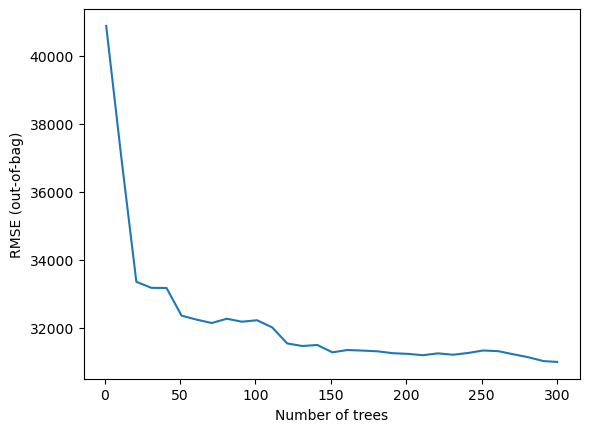

In [52]:
logs = rf.make_inspector().training_logs()
plt.plot([log.num_trees for log in logs], [log.evaluation.rmse for log in logs])
plt.xlabel("Number of trees")
plt.ylabel("RMSE (out-of-bag)")
plt.show()

In [53]:
inspector = rf.make_inspector()
inspector.evaluation()

Evaluation(num_examples=1061, accuracy=None, loss=None, rmse=31003.343656899597, ndcg=None, aucs=None, auuc=None, qini=None)

In [54]:
evaluation = rf.evaluate(x=valid_ds,return_dict=True)

for name, value in evaluation.items():
  print(f"{name}: {value:.4f}")

1/1 [==============================] - 1s 785ms/step - loss: 0.0000e+00 - mse: 579913664.0000
loss: 0.0000
mse: 579913664.0000


In [55]:
test_ds = tfdf.keras.pd_dataframe_to_tf_dataset(dataTest, task = tfdf.keras.Task.REGRESSION)
preds = rf.predict(test_ds)
output = pd.DataFrame({'Id': test['Id'], 'SalePrice': preds.squeeze()})

output.head()

2/2 [==============================] - 0s 23ms/step


,Id,SalePrice
0,1461,125839.914062
1,1462,154172.406250
2,1463,179190.765625
3,1464,182170.375000
4,1465,199049.187500


In [56]:
submit['SalePrice'] = rf.predict(test_ds)
submit.to_csv('/kaggle/working/submission.csv', index=False)
submit.head()

2/2 [==============================] - 0s 23ms/step


,Id,SalePrice
0,1461,125839.914062
1,1462,154172.406250
2,1463,179190.765625
3,1464,182170.375000
4,1465,199049.187500
